In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 例題30 レナード-ジョーンズ粒子系の構造最適化I

In [2]:
def golden(func, brack, args=()):
    gamma = (-1+np.sqrt(5))/2
    a, b, = brack
    p, q = b-(b-a)*gamma, a+(b-a)*gamma
    fa, fb, = func(a, *args), func(b, *args)
    fp, fq = func(p, *args), func(q, *args)
    for i in range(100):   # 最大ステップを100回に固定
        if fp <= fq:
            q, b, fq, fb = p, q, fp, fq
            p = b-(b-a)*gamma
            fp = func(p, *args)
        else:
            a, p, fa, fp = p, q, fp, fq
            q = a+(b-a)*gamma
            fq = func(q, *args)
        if (b-a)<1e-5: break   # 閾値を1e-5に指定
    return (b+a)/2
f = lambda x, e, s: 4*e*((s/x)**12-(s/x)**6)
r = golden(f, (1e-3,100), (1,1))
print(r, np.power(2,1/6))

1.122459923556337 1.122462048309373


# 例題31 レナード-ジョーンズ粒子系の構造最適化II

In [3]:
def lattice(L):
    r1d = np.linspace(0, L, L, endpoint=False)
    x, y = np.meshgrid(r1d, r1d)
    return np.array([x.flatten(), y.flatten()])

In [4]:
def dxy(x, L, avec, rcut):
    # 粒子の座標をx = n0*avec[0] + n1*avec[1]と表したとき，
    # x[:N]がN粒子のn0成分，x[N:]がn1成分に対応
    n0, n1 = x.reshape(2,L**2)
    dn0, dn1 = n0[None,:]-n0[:,None], n1[None,:]-n1[:,None]
    dn0 = np.where(abs(dn0)>0.5*L, dn0-np.sign(dn0)*L, dn0)
    dn1 = np.where(abs(dn1)>0.5*L, dn1-np.sign(dn1)*L, dn1)
    # 周期境界条件より，短いほうの距離で計算するための補正
    dxy = avec.T@np.array([dn0.flatten(), dn1.flatten()])
    # n0, n1 => x, yに変換
    dr = np.linalg.norm(dxy, axis=0)
    dr = np.where(dr>rcut, 1e+9, dr)
    # r > rcutの粒子間相互作用が効かないように補正
    dr = dr + 1e+9*np.eye(L**2).flatten()
    # 同様に，同一粒子(i=j)の寄与が効かないように補正
    return dxy[0], dxy[1], dr

In [5]:
def energy_a(a, x, L, s, e, avec, rcut):
    dx, dy, dr = dxy(x, L, a*avec, rcut)
    u = 4*e*((s/dr)**12 - (s/dr)**6)
    return np.sum(u) / L**2 / 2

In [6]:
# テキストには含まれない
L, e, s, rcut = 10, 1, 1, 5
x0 = lattice(L).flatten()
avec=np.array([[1,0],[0,1]])
A = golden(energy_a, (0.1,10), (x0, L, s, e, avec, rcut))
print(A, energy_a(A, x0, L, s, e, avec, rcut))

1.097321910159942 -2.666796262894441


In [7]:
L, e, s, rcut = 10, 1, 1, 5
x0 = lattice(L).flatten()
avec = np.array([[2,0],[1,np.sqrt(3)]])/2
A = golden(energy_a, (0.1,10), (x0, L, s, e, avec, rcut))
print(A, energy_a(A, x0, L, s, e, avec, rcut))

1.111601981294851 -3.3766854434570814


In [8]:
def forces(x, a, L, s, e, avec, rcut):
    dx, dy, dr = dxy(x, L, a*avec, rcut)
    fx = -(12*dx*(s/dr)**14 - 6*dx*(s/dr)**8)/s**2
    fy = -(12*dy*(s/dr)**14 - 6*dy*(s/dr)**8)/s**2
    fx = 4*e*np.sum(fx.reshape(L**2,L**2),axis=0)/L**2
    fy = 4*e*np.sum(fy.reshape(L**2,L**2),axis=0)/L**2
    fn01 = a*avec@np.array([fx, fy])
    return fn01.flatten()

In [9]:
# テキストには含まれない
def energy_x(x, a, L, s, e, avec, rcut):
    dx, dy, dr = dxy(x, L, a*avec, rcut)
    u = 4*e*((s/dr)**12 - (s/dr)**6)
    return np.sum(u) / L**2 / 2

In [10]:
from scipy.optimize import minimize
# ノイズを含んだ初期状態を準備
x0 = lattice(L) + 0.5*(np.random.rand(L**2)-0.5)
# jacで一階微分を計算する関数を指定する。今回はforce関数
sol = minimize(energy_x, x0, jac=forces, \
      args=(A, L, s, e, avec, rcut), method='CG')

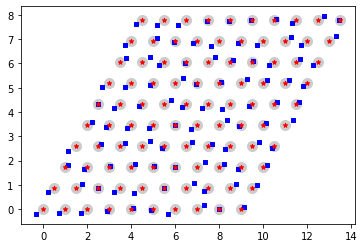

In [11]:
x0, x1 = x0.reshape((2, L**2)), sol.x.reshape((2,L**2))
x, x0, x1 = avec.T@lattice(L), avec.T@x0, avec.T@x1
plt.scatter(x[0], x[1], s=100, c='0.8', marker="o")
plt.scatter(x0[0], x0[1], s=10, c="blue", marker=",")
plt.scatter(x1[0], x1[1], s=20, c="red", marker="*")
plt.show()

# 例題32 ベイズ最適化

In [12]:
def GPfunc(xn, fn, x_grid):
    kernel = lambda x: np.exp(-x**2/2)
    Sinv = np.linalg.inv(kernel(xn[:,None] - xn[None,:]))
    kn = kernel(xn[:,None] - x_grid[None,:])
    mu = kn.T@Sinv@fn
    sigma = 1 - np.sum(kn*(Sinv@kn),axis=0)
    return mu, sigma

In [13]:
def plot_GP(func, x_grid, mu, sigma, beta):
    plt.ylim(-beta,beta)
    plt.plot(x_grid, mu, c="black", ls="dashed")
    plt.plot(x_grid, function(x_grid), c="yellow")
    hb, lb = mu + beta*sigma, mu - beta*sigma
    plt.fill_between(x_grid, hb, lb, color="0.7")
    plt.scatter(xn, fn)
    plt.show()

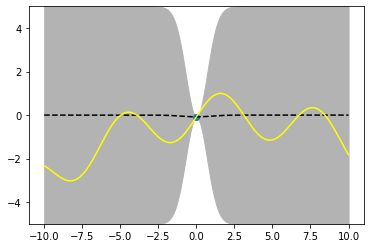

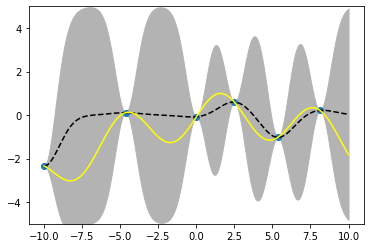

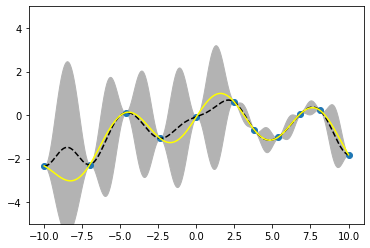

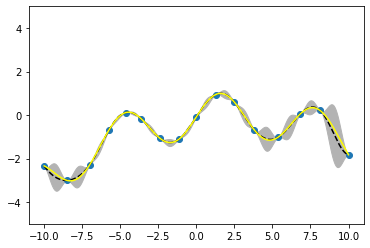

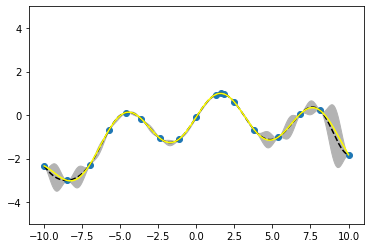

In [14]:
function = lambda x: np.sin(x) - 0.02*(x-2)**2
xn, fn, new_x, beta = [], [], np.random.uniform(-10,10), 5
# 初期値x0をランダムは設定した
new_x = 0.0
x_grid = np.linspace(-10,10,1000)
for i in range(100):
    if new_x in xn: break
    xn.append(new_x)
    fn.append(function(new_x)) # 関数の評価
    mu, sigma = GPfunc(np.array(xn), np.array(fn), x_grid)
    acqui = mu + beta*sigma
    new_x = x_grid[np.argmax(acqui)] 
    # np.argmaxでacquiが最大のインデックスを取得
    if(i%5==0): # 5ステップ毎に状況を図示
        plot_GP(function, x_grid, mu, sigma, beta)
plot_GP(function, x_grid, mu, sigma, beta)

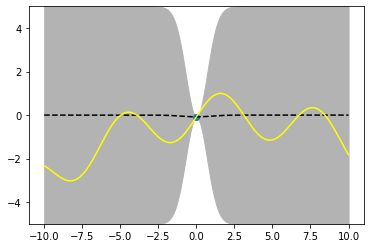

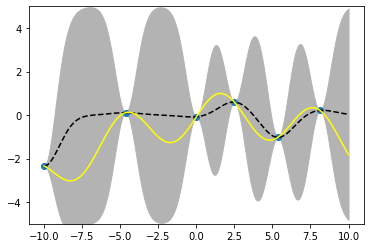

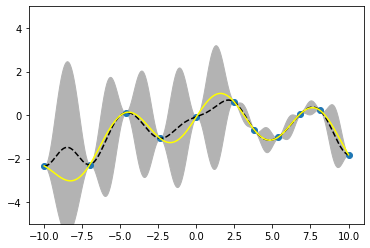

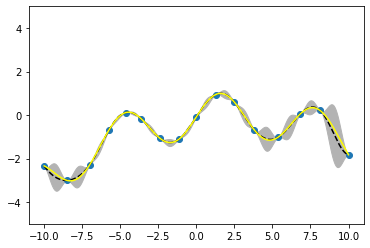

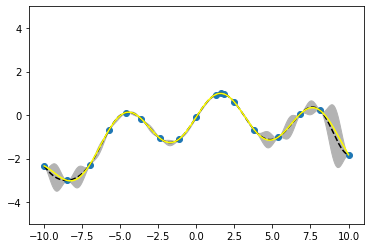

In [15]:
# テキストには含まれない(逆行列計算をしないもの)
def GPfunc(xn, fn, x_grid, Sinv):
    kernel = lambda x: np.exp(-x**2/2)
    kn = kernel(xn[:,None] - x_grid[None,:])
    mu = kn.T@Sinv@fn
    sigma = 1 - np.sum(kn*(Sinv@kn),axis=0)
    return mu, sigma

def update_Sinv(x, xn, Sinv):
    kernel = lambda x: np.exp(-x**2/2)
    n, kn = len(Sinv), kernel(xn - x)
    Sinv_kn = Sinv@kn
    sinv = 1/(1 - np.dot(kn, Sinv_kn))
    new_Sinv = np.zeros((n+1, n+1))
    new_Sinv[:n, :n] = Sinv + np.outer(Sinv_kn,Sinv_kn) * sinv
    new_Sinv[n, :n] = -Sinv_kn * sinv
    new_Sinv[:n, n] = -Sinv_kn * sinv
    new_Sinv[n,n] = sinv
    return new_Sinv

def plot_GP(func, x_grid, mu, sigma, beta):
    plt.ylim(-beta, beta)
    plt.plot(x_grid, mu, c="black", ls="dashed")
    plt.plot(x_grid, function(x_grid), c="yellow")
    hb, lb = mu + beta*sigma, mu - beta*sigma
    plt.fill_between(x_grid, hb, lb, color="0.7")
    plt.scatter(xn, fn)
    plt.show()

function = lambda x: np.sin(x) - 0.02*(x-2)**2
xn, fn, new_x, beta = [], [], np.random.uniform(-10,10), 5
x_grid = np.linspace(-10,10,1000)
Sinv = np.ones((1,1))
new_x = 0.0
for i in range(100):
    if new_x in xn: break
    xn.append(new_x)
    fn.append(function(new_x))
    mu, sigma = GPfunc(np.array(xn), np.array(fn), x_grid, Sinv)
    acqui = mu + beta*sigma
    new_x = x_grid[np.argmax(acqui)]
    Sinv = update_Sinv(new_x, np.array(xn), Sinv)
    if(i%5==0):
        plot_GP(function, x_grid, mu, sigma, beta)
plot_GP(function, x_grid, mu, sigma, beta)